In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np

def read_fasta(file_name):
    fastas = []
    for i,line in enumerate(open(file_name)):
        if (i%2 == 1):
            line = line.rstrip()
            if len(line)>=1000:
                fastas.append(line)
    return fastas

def one_hot_encode_along_row_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #zeros_array should be an array of dim 4xlen(sequence), filled with zeros.
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

In [27]:
#Load Data

import numpy as np
import h5py
path = "/srv/scratch/benbond/flex_spacing_tests/Nanog/"
filename = 'train_data.hdf5'
f = h5py.File(path + filename, 'r')

Y = np.array(f['Y']['output'])
Y = Y.reshape(-1)
X = np.array(f['X']['sequence'])



In [28]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Activation, Flatten
model = Sequential()
seq_len=1000
model.add(Conv1D(filters=15, kernel_size=15, strides=1, padding='valid', dilation_rate=1, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,input_shape=(seq_len,4)))
model.add(Conv1D(filters=15, kernel_size=15, strides=1, padding='valid', dilation_rate=1, activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(Conv1D(filters=15, kernel_size=15, strides=1, padding='valid', dilation_rate=1, activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(MaxPooling1D(strides=40, pool_size=40))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation("sigmoid"))


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 986, 15)           915       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 972, 15)           3390      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 958, 15)           3390      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 23, 15)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 345)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 346       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [29]:
num_samples = 15000
p = np.random.permutation(X.shape[0])
p = p[:num_samples]

X = X[p,:,:]
Y = Y[p]
X.shape

(15000, 1000, 4)

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

model.compile(optimizer='Adam',loss='binary_crossentropy')
model.fit(X,Y,validation_split=.2,epochs=10,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)])

Train on 12000 samples, validate on 3000 samples
Epoch 1/10
12000/12000 [==============================] - 12s - loss: 0.6841 - val_loss: 0.6688
Epoch 2/10
12000/12000 [==============================] - 11s - loss: 0.6640 - val_loss: 0.6641
Epoch 3/10
12000/12000 [==============================] - 11s - loss: 0.6440 - val_loss: 0.6254
Epoch 4/10
12000/12000 [==============================] - 12s - loss: 0.5870 - val_loss: 0.5681
Epoch 5/10
12000/12000 [==============================] - 11s - loss: 0.5460 - val_loss: 0.5326
Epoch 6/10
12000/12000 [==============================] - 12s - loss: 0.5173 - val_loss: 0.5144
Epoch 7/10
12000/12000 [==============================] - 12s - loss: 0.4979 - val_loss: 0.5334
Epoch 8/10
12000/12000 [==============================] - 12s - loss: 0.4746 - val_loss: 0.4977
Epoch 9/10
12000/12000 [==============================] - 11s - loss: 0.4669 - val_loss: 0.4984
Epoch 10/10
12000/12000 [==============================] - 12s - loss: 0.4419 - val_los

In [31]:
saved_hdf5_file_path='saved_keras2.0.hdf5'
print saved_hdf5_file_path
model.save(saved_hdf5_file_path)

saved_keras2.0.hdf5


In [ ]:
#to get deeplift

#!rm -rf deeplift
#!git clone https://github.com/kundajelab/deeplift.git
#!git checkout keras2compat#will clone the deeplift repository
#!pip install --editable deeplift/

In [32]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

In [33]:
print 'converting to deeplift model'
saved_hdf5_file_path='saved_keras2.0.hdf5'
deeplift_model = kc.convert_model_from_saved_files(saved_hdf5_file_path,
                                                   nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 

converting to deeplift model
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 1 the preceding linear layer is preact_1 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer 6 the preceding linear layer is 5 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_Ge

In [36]:
import copy

def convert_one_hot_to_fastas(one_hot):
    fastas=[]
    for i in range(one_hot.shape[0]):
        if i%1000==0:
            print i
        cur_seq=one_hot[i,:,:]
        cur_fasta=np.array(['N']*one_hot.shape[1])
        base_dict = {0:'A', 1:'C', 2:'G', 3:'T',4:'N'}
        bases = [ one_hot[i,j,:].argmax() for j in range(1000) ]
        bases = [ base_dict[x] for x in bases  ]
        cur_seq=''.join(bases)
        
        fastas.append(''.join(cur_fasta))
    return fastas
        
fastas=convert_one_hot_to_fastas(copy.deepcopy(X[:,:,:]))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [11]:
!pip show tensorflow

Name: tensorflow
Version: 1.7.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /mnt/lab_data/kundaje/users/oursu/code/anaconda2/myanaconda/lib/python2.7/site-packages
Requires: protobuf, astor, backports.weakref, wheel, mock, enum34, gast, termcolor, absl-py, tensorboard, six, grpcio, numpy
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

find_scores_layer_idx = 0

print 'deelift contribs func'
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=-2)

print 'scoring func'
scoring_func = get_shuffle_seq_ref_function(
    score_computation_function=deeplift_contribs_func,
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_row_axis(seq) for seq in x]))



deelift contribs func
scoring func


In [45]:
print 'get deeplift scores'
deeplift_scores = scoring_func(
        task_idx=0,
        input_data_sequences=fastas,
        num_refs_per_seq=1,
        batch_size=200,
        progress_update=1000)


deeplift_scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X],
                                         batch_size=10,
                                         progress_update=1000))

get deeplift scores


TypeError: compute_scores_with_shuffle_seq_refs() got an unexpected keyword argument 'input_data_list'

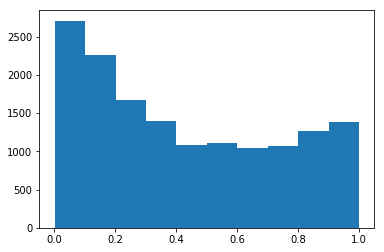

2.2033525


In [39]:
plt.hist(model.predict(X))
plt.show()
print np.max(deeplift_scores)

In [40]:
print np.max(X)
deeplift_scores = (X[:,:,:]*
                   np.sum(deeplift_scores, axis=2)[:,:,None])

1.0


In [41]:
print deeplift_scores.shape

np.max(deeplift_scores)

(15000, 1000, 4)


2.2033525

[0.8458417]


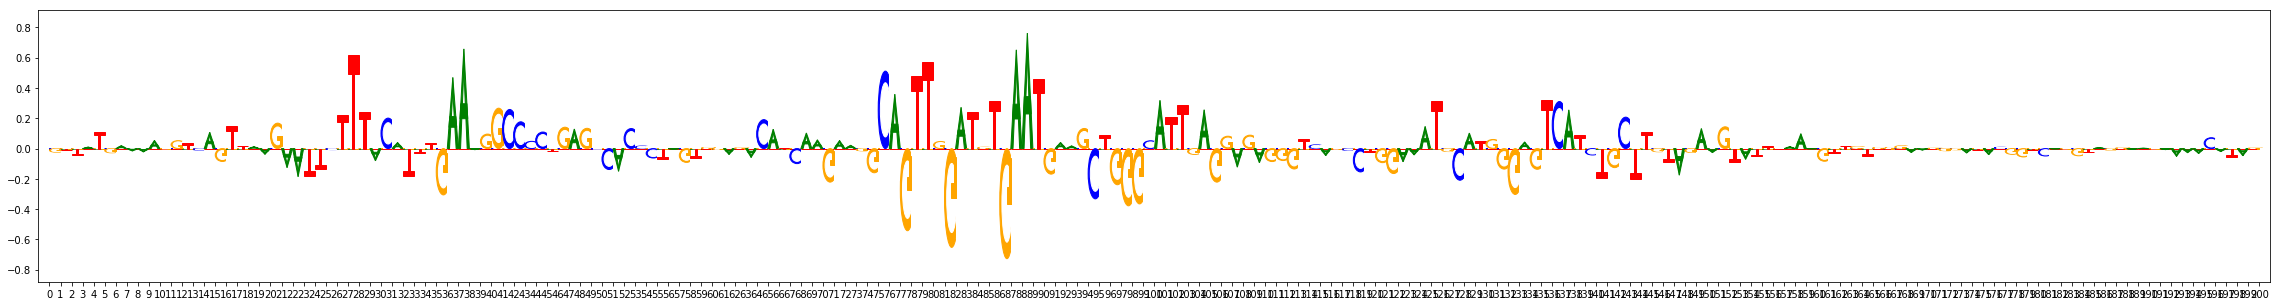

[0.9727763]


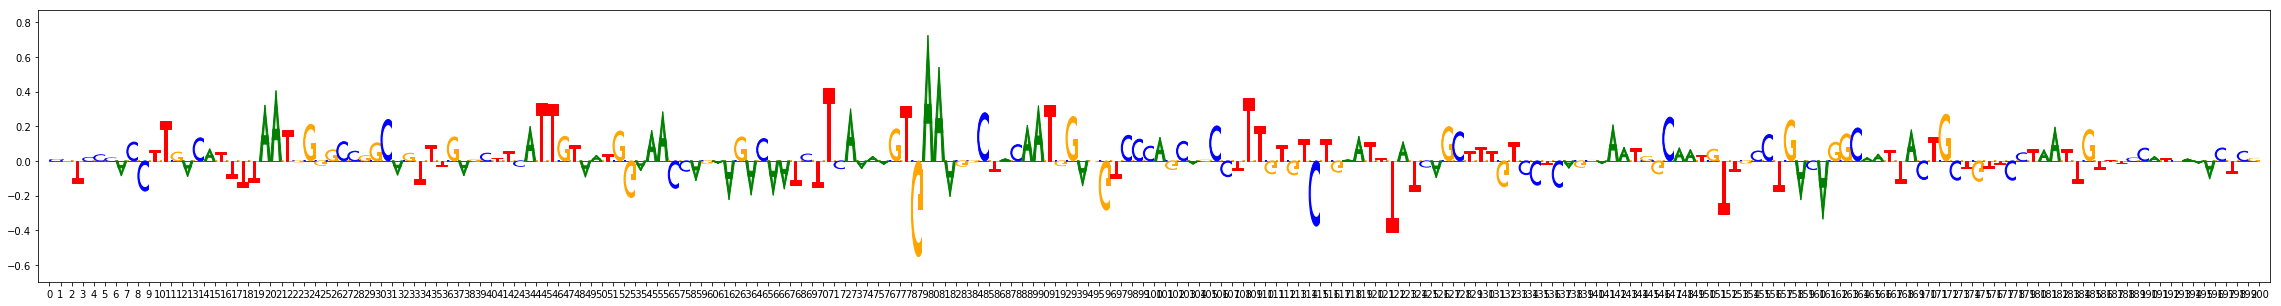

[0.7383395]


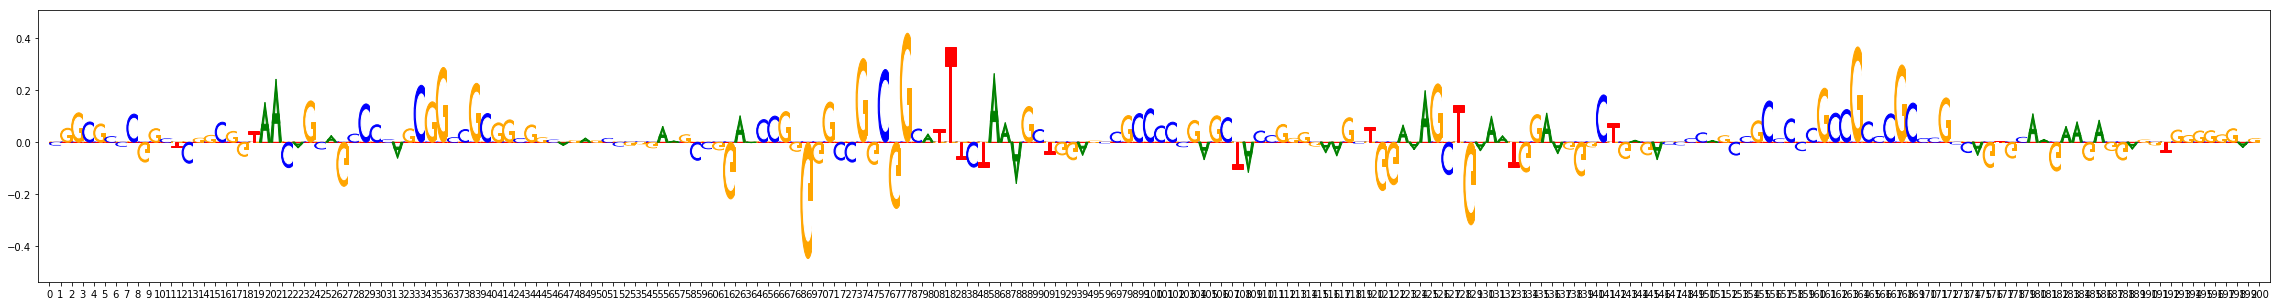

[0.8569873]


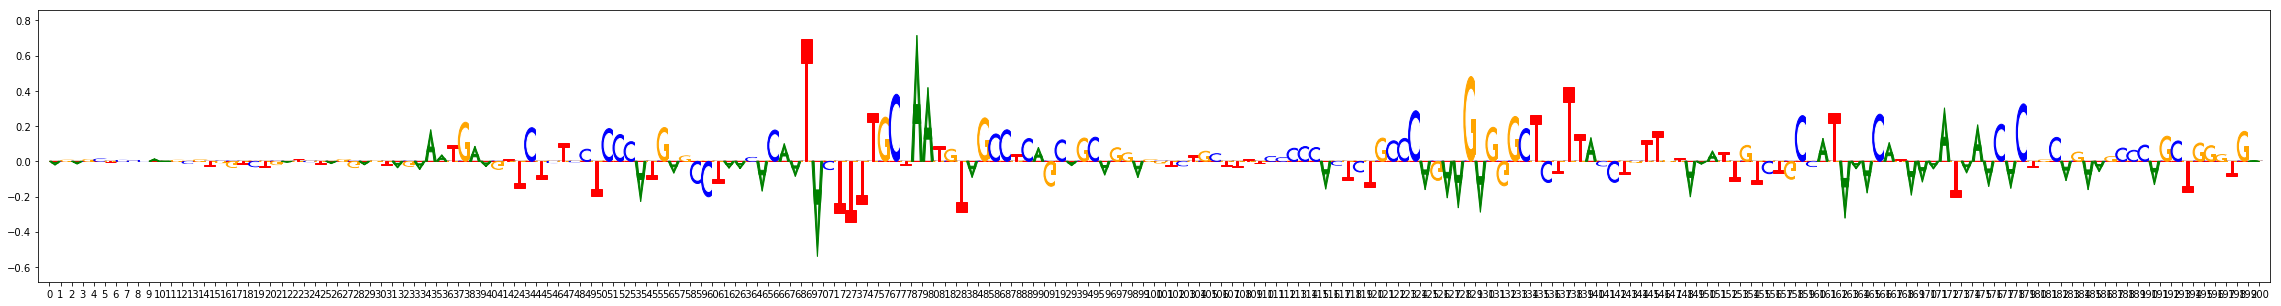

[0.7937733]


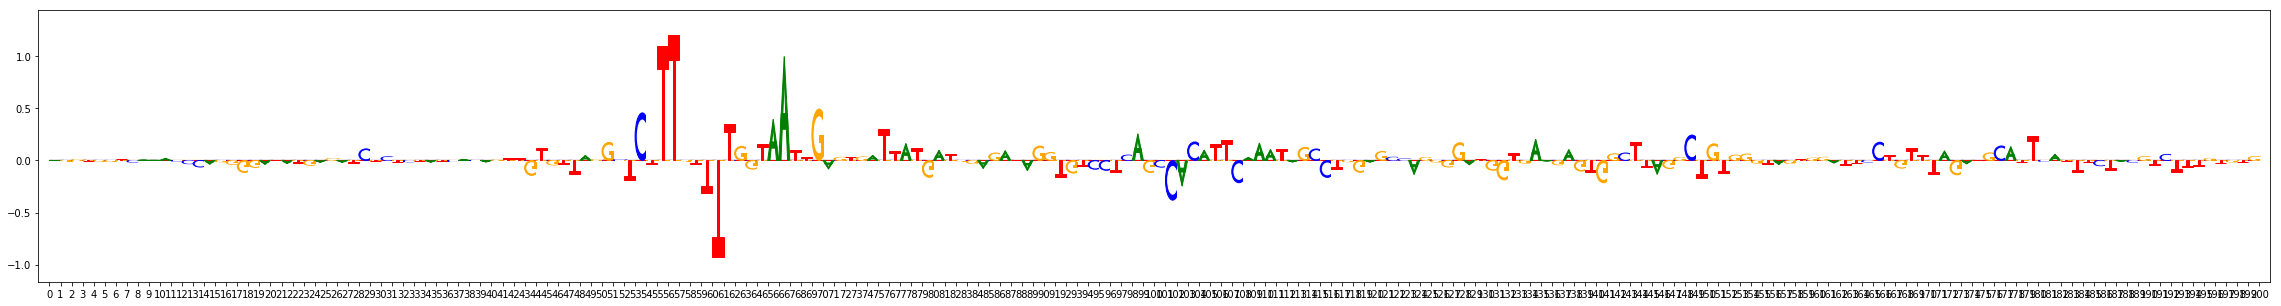

[0.9753753]


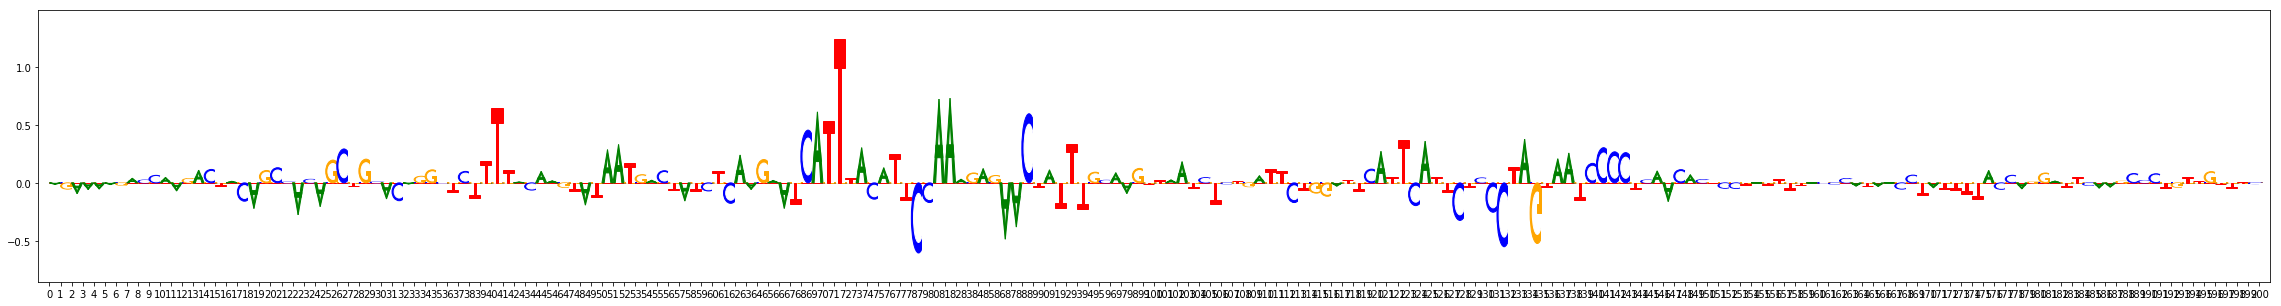

[0.9064061]


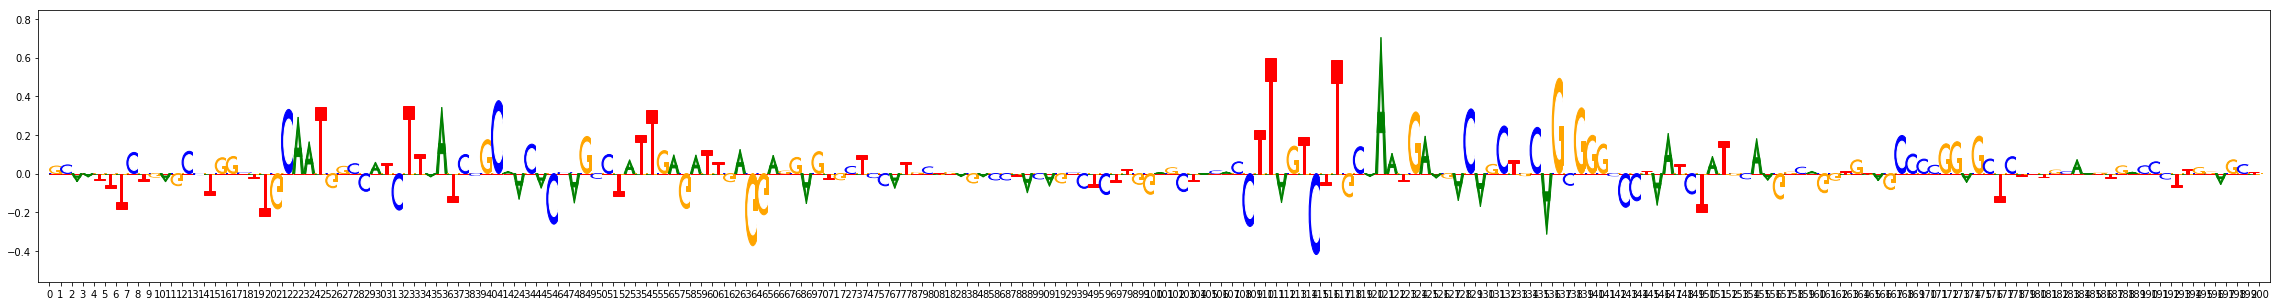

[0.90094703]


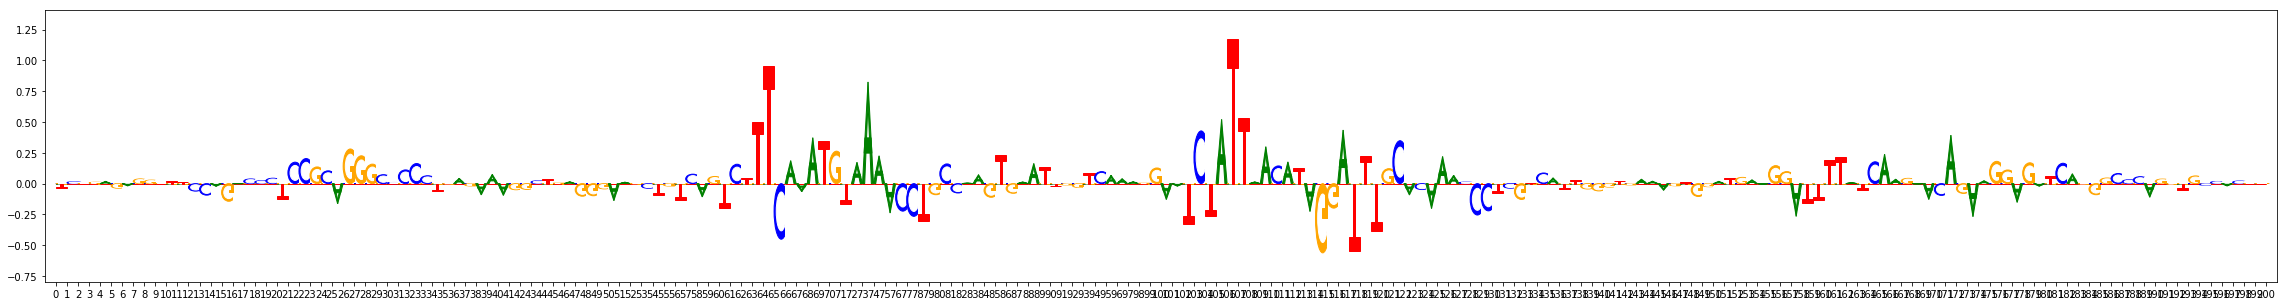

[0.87727714]


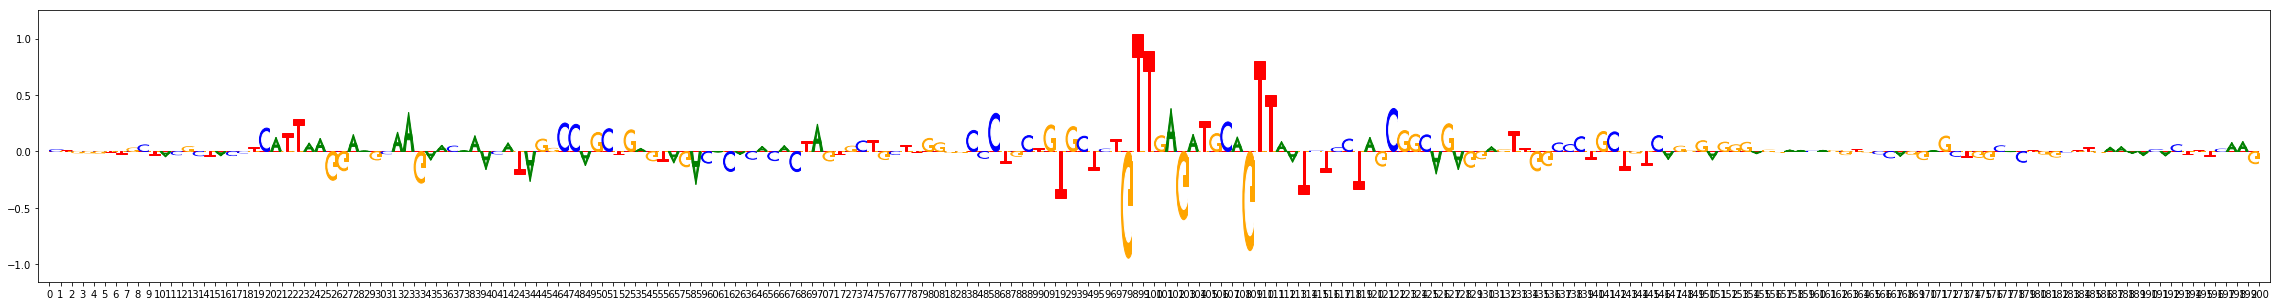

[0.8099368]


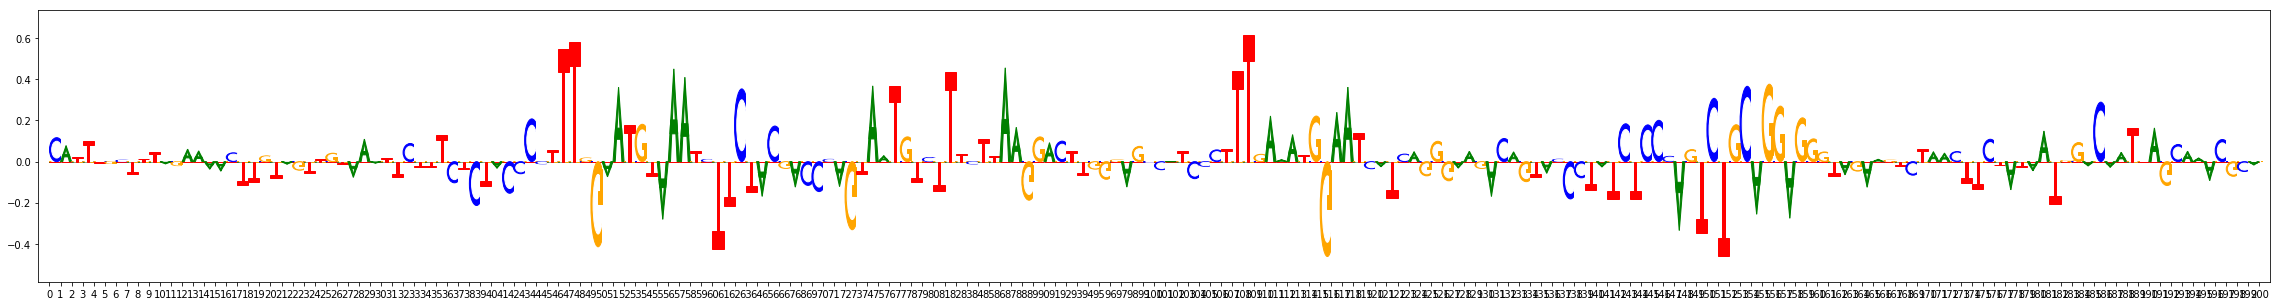

[0.9380441]


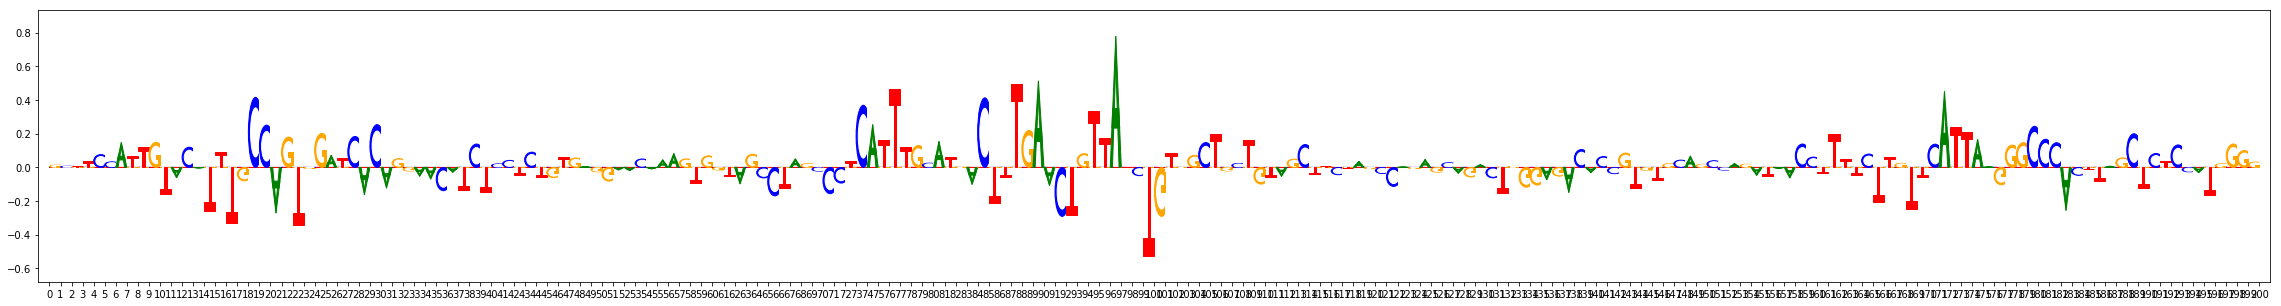

[0.75181305]


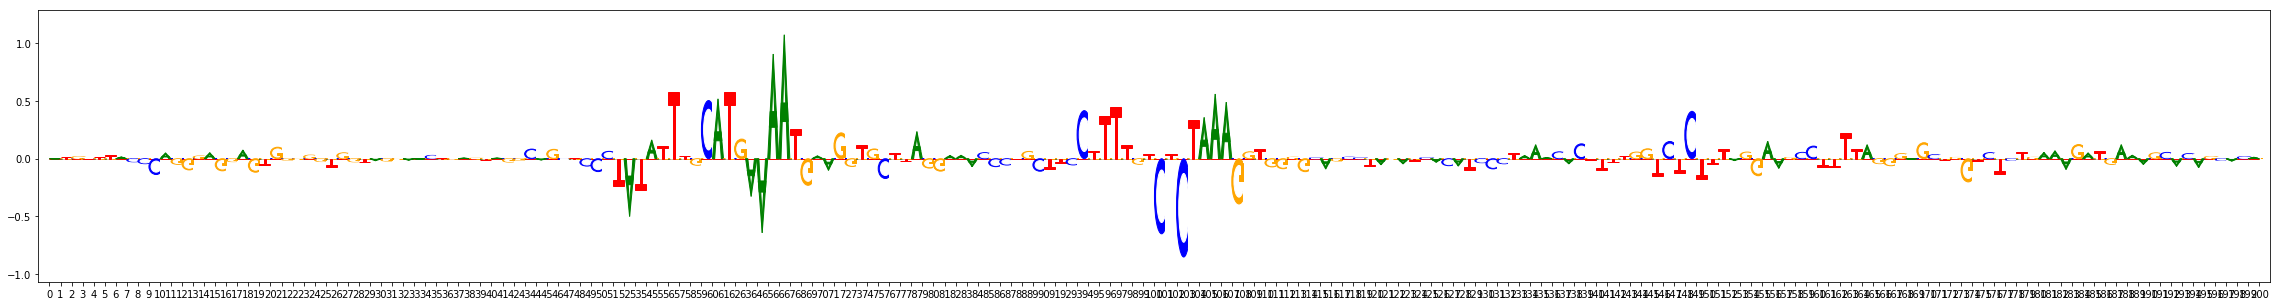

[0.71173847]


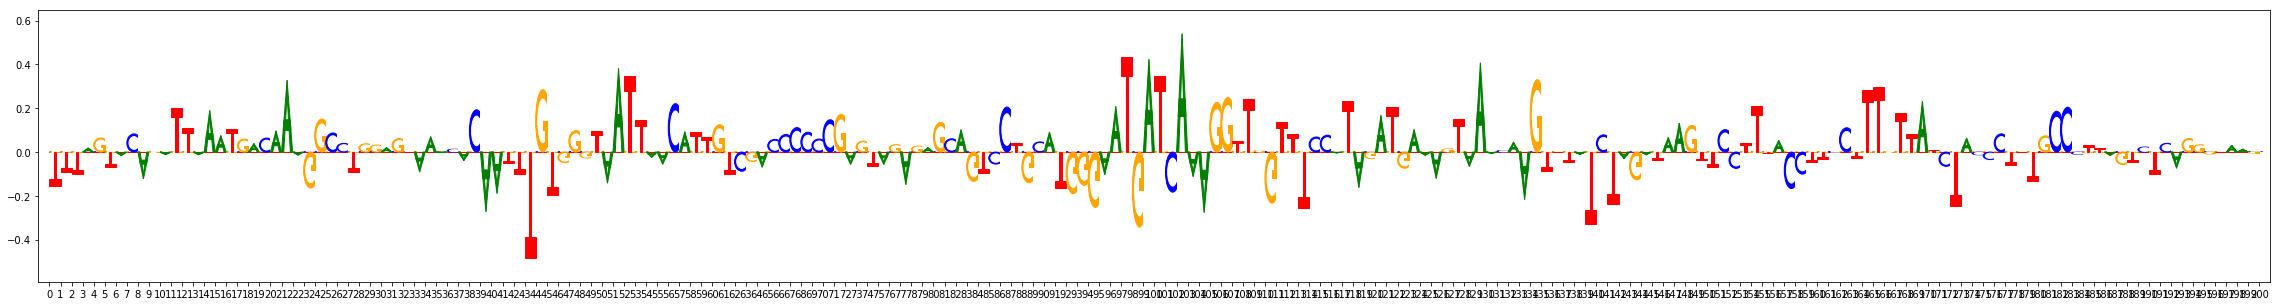

[0.8197115]


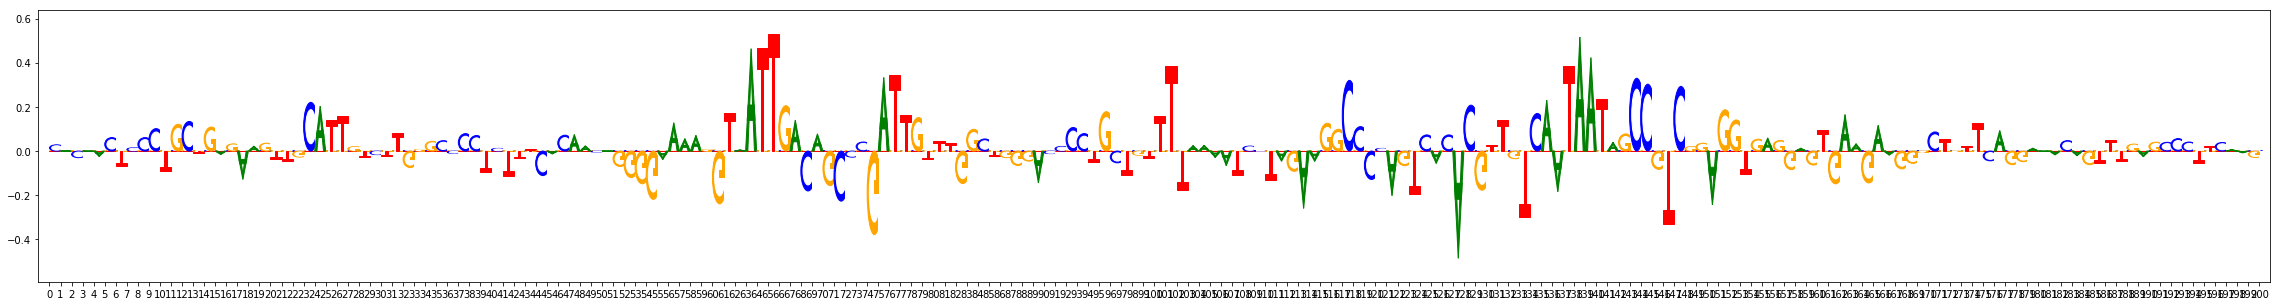

[0.78969085]


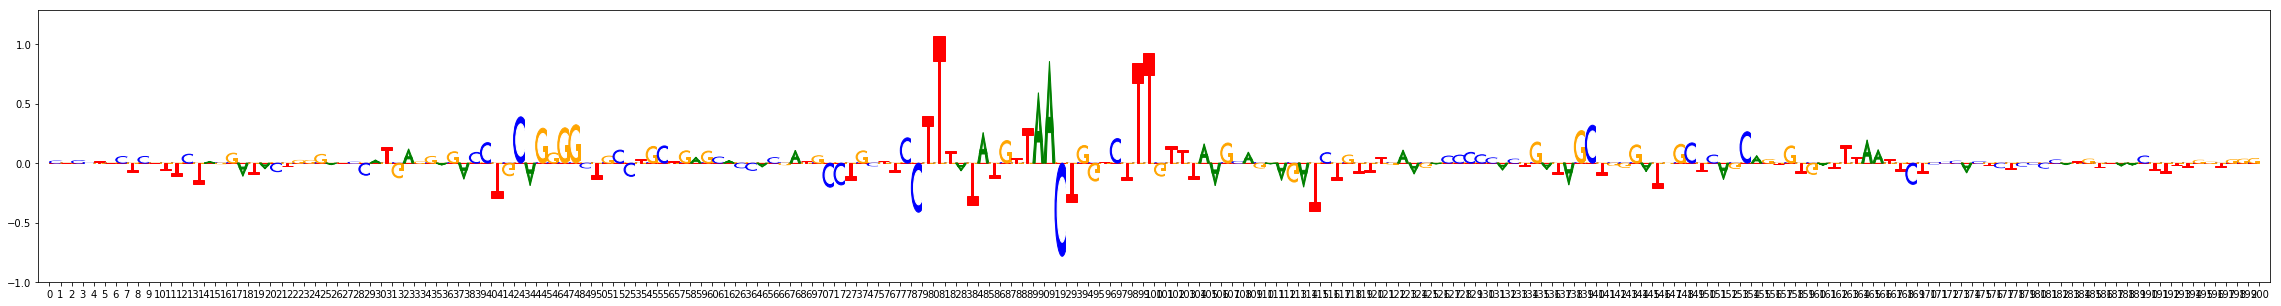

[0.72195274]


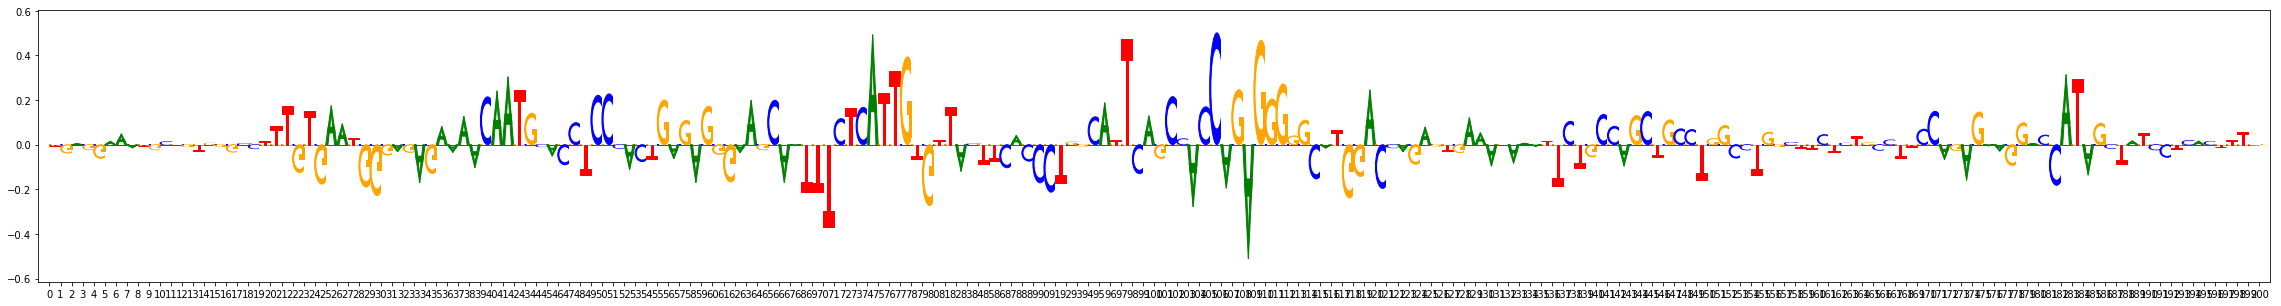

[0.9926023]


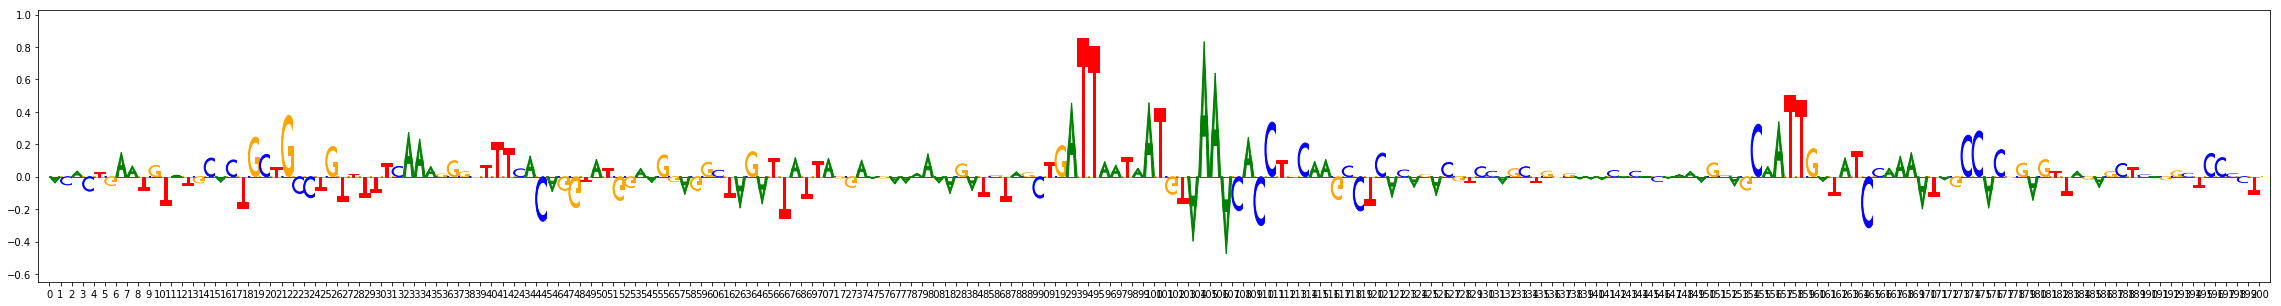

[0.8339207]


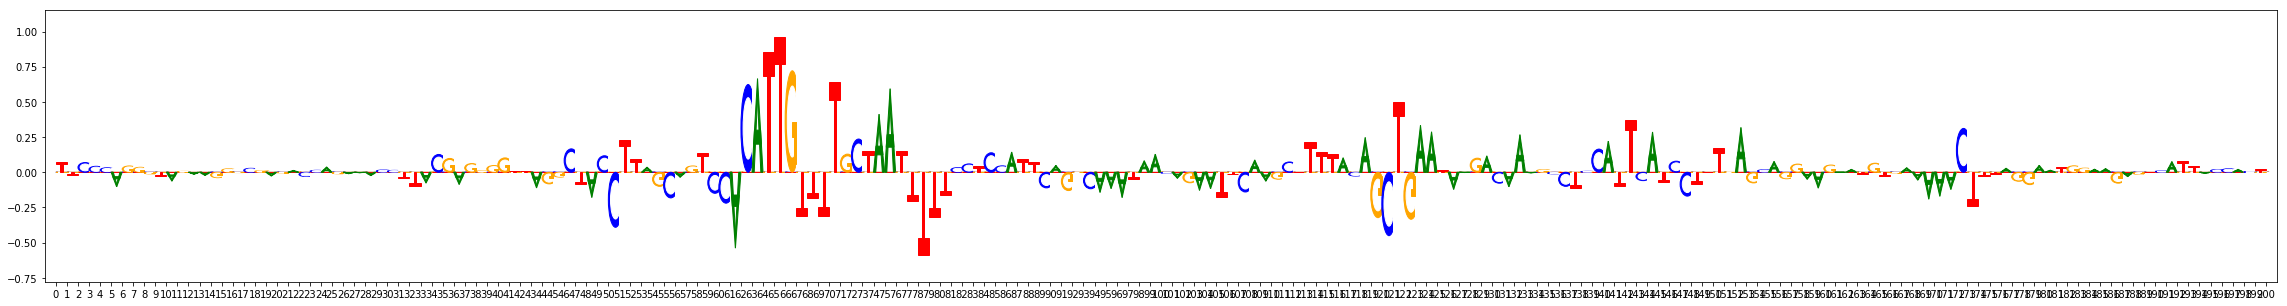

[0.87122273]


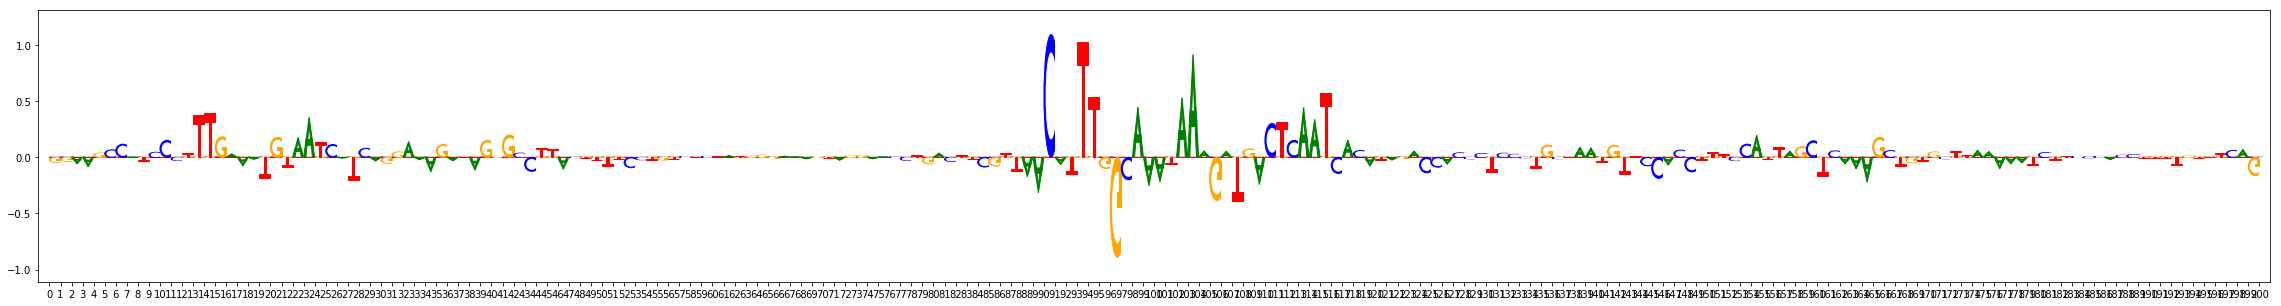

[0.7145276]


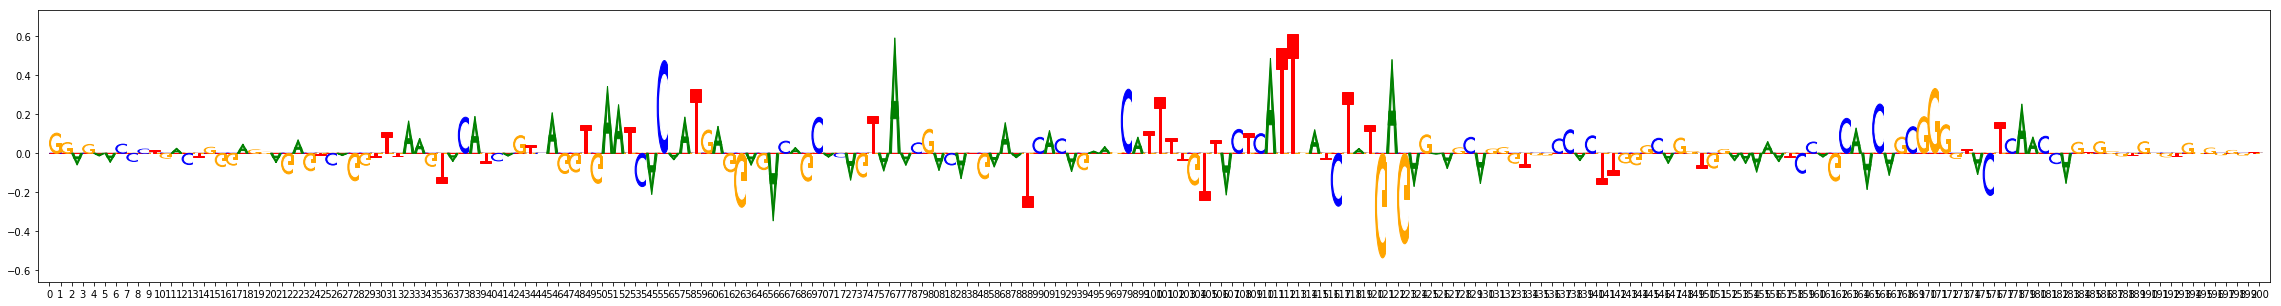

In [44]:
from deeplift.visualization import viz_sequence

model_predictions=model.predict(X)

for i in range(100):
    if model_predictions[i]>0.7:
        print (model_predictions[i])
        viz_sequence.plot_weights(deeplift_scores[i][400:600],
                                  figsize=(40,5))